In [48]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

import pickle
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report

In [34]:
with open('Xy.pkl', 'rb') as f:
    X, y = pickle.load(f)
print('Data loaded')

Data loaded


In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [36]:
cat = X.select_dtypes(exclude=np.number).columns.to_list()
num = X.select_dtypes(include=np.number).columns.to_list()
print(cat)
print(num)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
['tenure', 'MonthlyCharges', 'TotalCharges']


In [37]:
scaler = StandardScaler()
ohe = OneHotEncoder(drop= 'first', sparse_output=False)

preprocessor = ColumnTransformer(transformers=[('scaler', scaler, num),
                                               ('encoder', ohe, cat)]).set_output(transform='pandas')

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# Cross Validation

In [38]:
full_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('clf', LogisticRegression(random_state=0))])

scores = cross_val_score(full_pipeline, X_train, y_train, cv=5, scoring='accuracy')
print('Scores:', scores)
print('Mean:', np.mean(scores).round(3))
print('Std:', np.std(scores).round(3))

Scores: [0.80745342 0.80922804 0.81898846 0.80390417 0.77797513]
Mean: 0.804
Std: 0.014


# Hyperparameter Tuning

In [39]:
from sklearn.model_selection import GridSearchCV

param_grid = {'clf__C': [0.01, 0.1, 1, 10, 100]}
log_gs_acc = GridSearchCV(full_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
log_gs_acc.fit(X_train, y_train)
print('Best score:', log_gs_acc.best_score_.round(3))
print('Best params:', log_gs_acc.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best score: 0.805
Best params: {'clf__C': 100}


In [40]:
param_grid = {'clf__C': [0.01, 0.1, 1, 10, 100]}
log_gs_rec = GridSearchCV(full_pipeline, param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=3)
log_gs_rec.fit(X_train, y_train)
print('Best score:', log_gs_rec.best_score_.round(3))
print('Best params:', log_gs_rec.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best score: 0.555
Best params: {'clf__C': 10}


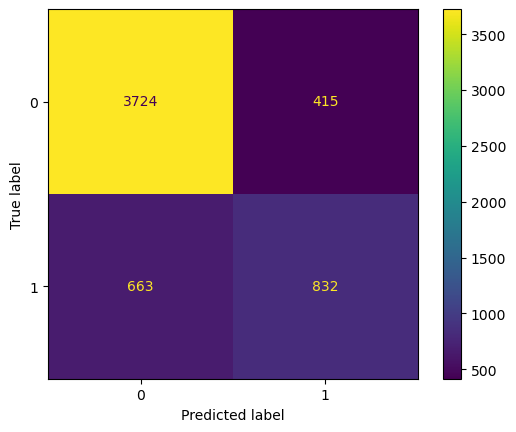

In [41]:
best_model = log_gs_acc.best_estimator_
y_pred = best_model.predict(X_train)

ConfusionMatrixDisplay.from_predictions(y_train, y_pred)

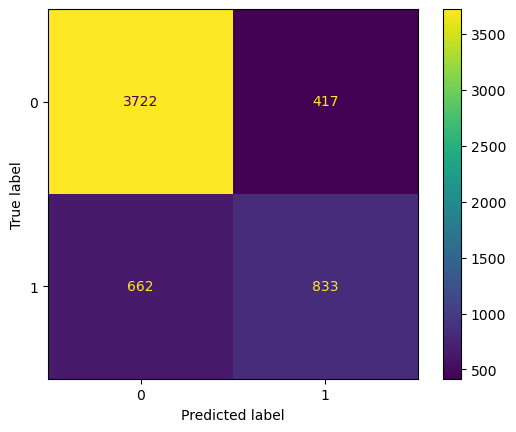

In [42]:
best_model = log_gs_rec.best_estimator_
y_pred = best_model.predict(X_train)

ConfusionMatrixDisplay.from_predictions(y_train, y_pred)

Accuracy: 0.81
Precision: 0.67
Recall: 0.56
F1 score: 0.61


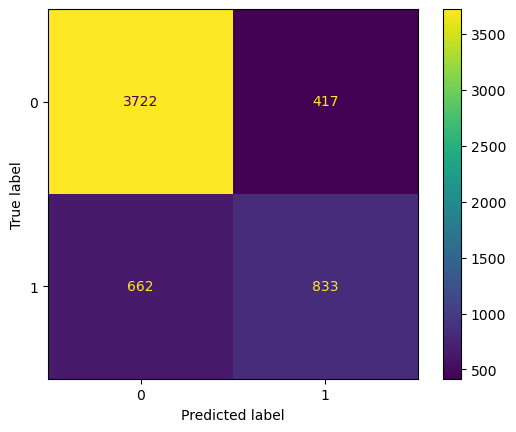

In [47]:
best_model = log_gs_rec.best_estimator_
y_pred = best_model.predict_proba(X_train)[:, 1] >= 0.5

ConfusionMatrixDisplay.from_predictions(y_train, y_pred)
print('Accuracy:', round(accuracy_score(y_train, y_pred),2))
print('Precision:', round(precision_score(y_train, y_pred),2))
print('Recall:', round(recall_score(y_train, y_pred),2))
print('F1 score:', round(f1_score(y_train, y_pred),2))

In [46]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4139
           1       0.67      0.56      0.61      1495

    accuracy                           0.81      5634
   macro avg       0.76      0.73      0.74      5634
weighted avg       0.80      0.81      0.80      5634



In [49]:
fn, fp, tn, tp = confusion_matrix(y_train, y_pred).ravel()
print('False negative:', fn)
print('False positive:', fp)
print('True negative:', tn)
print('True positive:', tp)

False negative: 3722
False positive: 417
True negative: 662
True positive: 833


In [ ]:
y_train.value_counts()   # Support

Churn
0    4139
1    1495
Name: count, dtype: int64

In [56]:
pos = 1
print('Precision:', round(precision_score(y_train, y_pred, pos_label=pos),2))
print('Recall:', round(recall_score(y_train, y_pred, pos_label=pos),2))
print('F1 score:', round(f1_score(y_train, y_pred, pos_label=pos),2))

Precision: 0.67
Recall: 0.56
F1 score: 0.61


In [52]:
pos = 0
print('Precision:', round(precision_score(y_train, y_pred, pos_label=pos),2))
print('Recall:', round(recall_score(y_train, y_pred, pos_label=pos),2))
print('F1 score:', round(f1_score(y_train, y_pred, pos_label=pos),2))

Precision: 0.85
Recall: 0.9
F1 score: 0.87


In [53]:
avg = 'macro'
print('Precision:', round(precision_score(y_train, y_pred, average=avg),2))
print('Recall:', round(recall_score(y_train, y_pred, average=avg),2))
print('F1 score:', round(f1_score(y_train, y_pred, average=avg),2))

Precision: 0.76
Recall: 0.73
F1 score: 0.74


In [ ]:
avg = 'weighted'
print('Precision:', round(precision_score(y_train, y_pred, average=avg),2))
print('Recall:', round(recall_score(y_train, y_pred, average=avg),2))
print('F1 score:', round(f1_score(y_train, y_pred, average=avg),2))

Precision: 0.8
Recall: 0.81
F1 score: 0.8


In [55]:
avg = 'micro'
print('Precision:', round(precision_score(y_train, y_pred, average=avg),2))
print('Recall:', round(recall_score(y_train, y_pred, average=avg),2))
print('F1 score:', round(f1_score(y_train, y_pred, average=avg),2))

Precision: 0.81
Recall: 0.81
F1 score: 0.81


In [58]:
param_grid = {'clf__C': [0.01, 0.1, 1, 10, 100]}
log_gs_rec = GridSearchCV(full_pipeline, param_grid, cv=5, scoring='recall_macro', n_jobs=-1, verbose=3)
log_gs_rec.fit(X_train, y_train)
print('Best score:', log_gs_rec.best_score_.round(3))
print('Best params:', log_gs_rec.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best score: 0.725
Best params: {'clf__C': 10}


In [59]:
aram_grid = {'clf__C': [0.01, 0.1, 1, 10, 100]}
log_gs_rec = GridSearchCV(full_pipeline, param_grid, cv=5, scoring='recall_weighted', n_jobs=-1, verbose=3)
log_gs_rec.fit(X_train, y_train)
print('Best score:', log_gs_rec.best_score_.round(3))
print('Best params:', log_gs_rec.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best score: 0.805
Best params: {'clf__C': 100}


In [63]:
from sklearn.metrics import precision_recall_curve
y_pred = best_model.predict_proba(X_train)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_train, y_pred)

prec_rec = pd.DataFrame(data={'Precision': precision[:-1], 'Recall': recall[:-1], 'Threshold': thresholds})
prec_rec.head()

,Precision,Recall,Threshold
0,0.265353,1.0,0.001217
1,0.265400,1.0,0.001251
2,0.265447,1.0,0.001284
3,0.265495,1.0,0.001290
4,0.265542,1.0,0.001309


In [65]:
prec_rec.tail()

,Precision,Recall,Threshold
5598,1.0,0.003344,0.836242
5599,1.0,0.002676,0.837648
5600,1.0,0.002007,0.840674
5601,1.0,0.001338,0.842325
5602,1.0,0.000669,0.847048


In [64]:
px.line(prec_rec, x='Recall', y='Precision', hover_data=['Threshold'], title='Precision-Recall Curve', width=800, height=600)

In [67]:
min_recall = 0.9
prec_rec[prec_rec['Recall'] >= min_recall].tail()

,Precision,Recall,Threshold
2637,0.449449,0.901003,0.170111
2638,0.449599,0.901003,0.170409
2639,0.449750,0.901003,0.170623
2640,0.449566,0.900334,0.170629
2641,0.449716,0.900334,0.170746


In [71]:
best_threshold = prec_rec.loc[prec_rec['Recall'] >= min_recall, 'Threshold'].max()
best_threshold

0.17074551309315558

In [72]:
# In case of precision
min_precision = 0.85
best_threshold = prec_rec.loc[prec_rec['Precision'] >= min_precision, 'Threshold'].min()
best_threshold

0.735671748974643

In [73]:
from sklearn.metrics import roc_curve
y_pred = best_model.predict_proba(X_train)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, y_pred)
roc = pd.DataFrame(data={'False Positive Rate': fpr, 'True Positive Rate': tpr, 'Threshold': thresholds})

px.line(roc, x='False Positive Rate', y='True Positive Rate', hover_data=['Threshold'], title='ROC Curve', width=800, height=600)

In [74]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train, y_pred)

0.8475627464019956

In [ ]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='most_frequent')

dummy_clf.fit(X_train, y_train)

,strategy,'most_frequent'
,random_state,None
,constant,None


In [77]:
# PLot ROC curve
y_pred = dummy_clf.predict_proba(X_train)[:, 1]
fpr_dummy, tpr_dummy, thresholds = roc_curve(y_train, y_pred)

roc_dummy = pd.DataFrame(data={'False Positive Rate': fpr_dummy, 'True Positive Rate': tpr_dummy, 'Threshold': thresholds})

In [82]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=roc['False Positive Rate'], y=roc['True Positive Rate'], mode='lines', name='Logistic Regression'))
fig.add_trace(go.Scatter(x=roc_dummy['False Positive Rate'], y=roc_dummy['True Positive Rate'], mode='lines', name='Dummy Classifier'))

fig.update_layout(title='ROC Curve', xaxis_title='False Positive Rate', yaxis_title='True Positive Rate', width=800, height=600)
fig.show()

In [83]:
y_pred_dummy = dummy_clf.predict(X_train)
roc_auc_score(y_train, y_pred_dummy)

0.5

In [84]:
param_grid = {'clf__C': [0.01, 0.1, 1, 10, 100]}
log_gs_acc = GridSearchCV(full_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=3)
log_gs_acc.fit(X_train, y_train)
print('Best score:', log_gs_acc.best_score_.round(3))
print('Best params:', log_gs_acc.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best score: 0.844
Best params: {'clf__C': 10}
